In [103]:
suppressMessages(library(rwwa))
png_res <- 240

# Exploratory analysis - HDWI

In [104]:
cov_df <- merge(read.table("ts/gmst.dat", col.names = c("year", "gmst")),
                load_ts("ts/med-storms_nao-djf_era5-stn.dat", col.names = c("year", "nao")))
cov_df$gmst <- cov_df$gmst - cov_df$gmst[cov_df$year == 2026]
cov_df$nao_res <- resid(lm(nao ~ gmst, cov_df))

cov_2026 <- cov_df[cov_df$year == 2026,c(-1),drop = F]
cov_cf <- rbind("pi" = cov_2026 - c(1.3,0,0),
                "naoneutral" = c(cov_2026$gmst, 0,0))

In [105]:
rnm <- "Box3"

df_list <- sapply(list.files("ts", pattern = paste0(rnm,"_DJF_rx1d"), full.names = T), 
       function(fnm) load_ts(fnm, col.names = c("year", gsub(".+/|_.+","",fnm))), simplify = F)

In [106]:
ts_df <- Reduce(function(df1, df2) merge(df1, df2, by = "year", all.x = TRUE, all.y = TRUE), df_list)
ts_df$year <- ts_df$year + 1

In [118]:
df <- merge(cov_df, ts_df, all.x = T)
df <- df[,colnames(df) != "MSWX"]

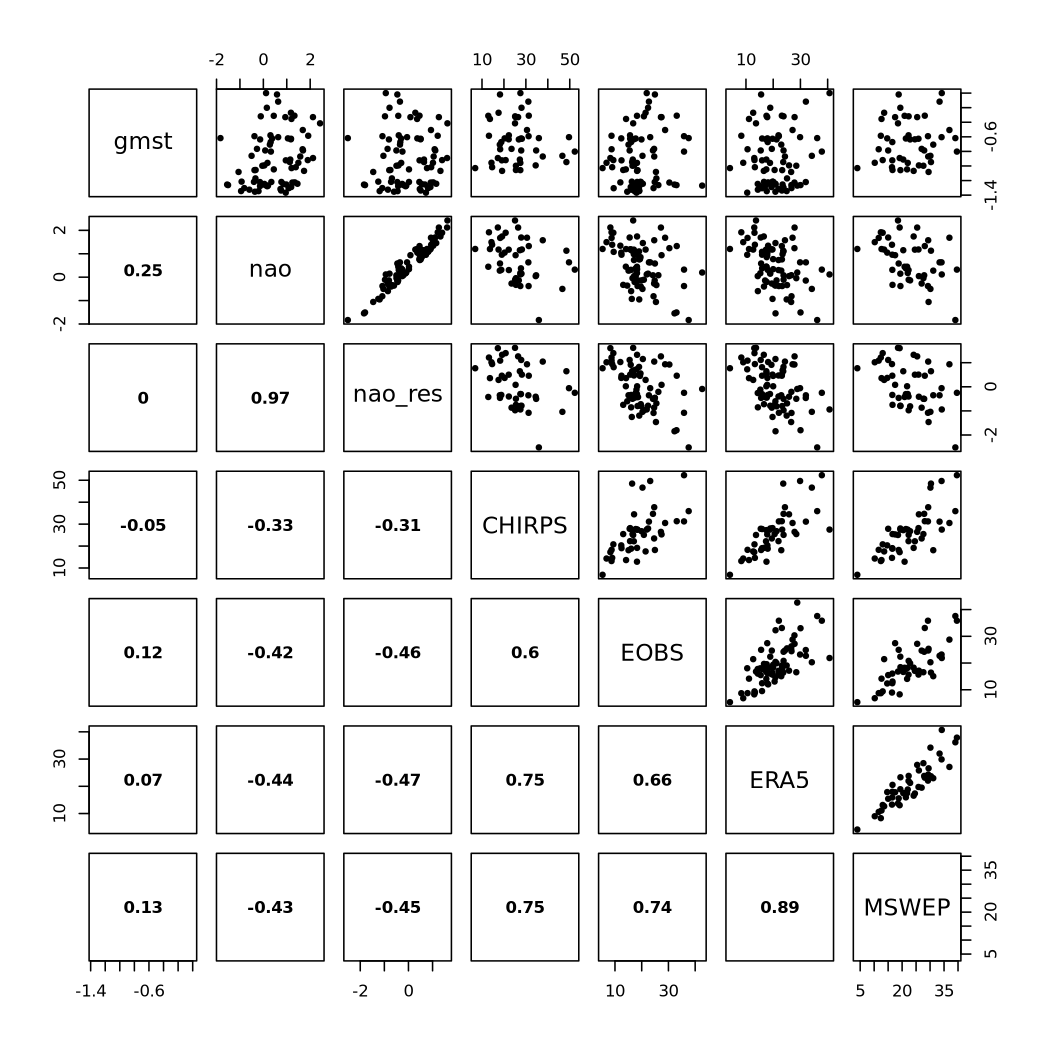

In [119]:
prep_window(res = 150, h = 7, w = 7)
pairs(df[,-1], lower.panel = panel.cor)

In [120]:
mdl_gmst_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "gmst", varnm = cnm, lower = F)
}, simplify = F)

mdl_gmstnaores_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = c("gmst", "nao_res"), varnm = cnm, lower = F)
}, simplify = F)

mdl_gmstnao_fixeddisp <- sapply(colnames(df)[-(1:4)], function(cnm) {
    fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = c("gmst", "nao"), varnm = cnm, lower = F)
}, simplify = F)

In [121]:
# NAO it is.
round(rbind("GMST only" = sapply(mdl_gmst_fixeddisp, aic),
            "GMST + NAO" = sapply(mdl_gmstnao_fixeddisp, aic),
            "GMST + NAO (detrended)" = sapply(mdl_gmstnaores_fixeddisp, aic)), 1)

,CHIRPS,EOBS,ERA5,MSWEP
GMST only,342.9,524.4,519.2,341.1
GMST + NAO,339.5,507.9,504.7,336.1
GMST + NAO (detrended),339.5,507.9,504.7,336.1


In [122]:
res <- sapply(list("GMST only" = mdl_gmst_fixeddisp,
                   "GMST + NAO" = mdl_gmstnao_fixeddisp,
                   "GMST + NAO (detrended)" = mdl_gmstnaores_fixeddisp),
              function(mlist) sapply(mlist, mdl_ests, cov_f = cov_2026, cov_cf = cov_cf), simplify = F)

In [123]:
cat("alpha_gmst parameter:")
round(sapply(res, "[", "alpha_gmst",),2)
cat("\n")

cat("% change in intensity (GMST):")
round(sapply(res, "[", "dI_rel_pi",),2)
cat("\n")

cat("% change in intensity (NAO):")
round(sapply(res, "[", "dI_rel_naoneutral",),2)
cat("\n")

alpha_gmst parameter:

,GMST only,GMST + NAO,GMST + NAO (detrended)
CHIRPS,-1.63,-0.94,-2.56
EOBS,2.03,5.76,2.20
ERA5,2.29,4.05,1.56
MSWEP,2.53,4.23,1.98



% change in intensity (GMST):

,GMST only,GMST + NAO,GMST + NAO (detrended)
CHIRPS,-9.70,-5.02,-15.12
EOBS,15.46,38.49,16.93
ERA5,15.89,25.56,10.93
MSWEP,16.42,25.30,12.89



% change in intensity (NAO):

,GMST only,GMST + NAO,GMST + NAO (detrended)
CHIRPS,0,-1.64,14.41
EOBS,0,-2.45,22.39
ERA5,0,-1.81,15.98
MSWEP,0,-1.52,13.30


In [124]:
round(res[[3]], 1)[c("event_magnitude", "return_period", "PR_pi", "dI_rel_pi", "PR_naoneutral", "dI_rel_naoneutral"),]

,CHIRPS,EOBS,ERA5,MSWEP
event_magnitude,27.5,21.9,40.7,34.2
return_period,2.2,1.5,36.0,4.5
PR_pi,0.7,1.4,4.7,2.0
dI_rel_pi,-15.1,16.9,10.9,12.9
PR_naoneutral,1.5,1.6,12.1,2.1
dI_rel_naoneutral,14.4,22.4,16.0,13.3


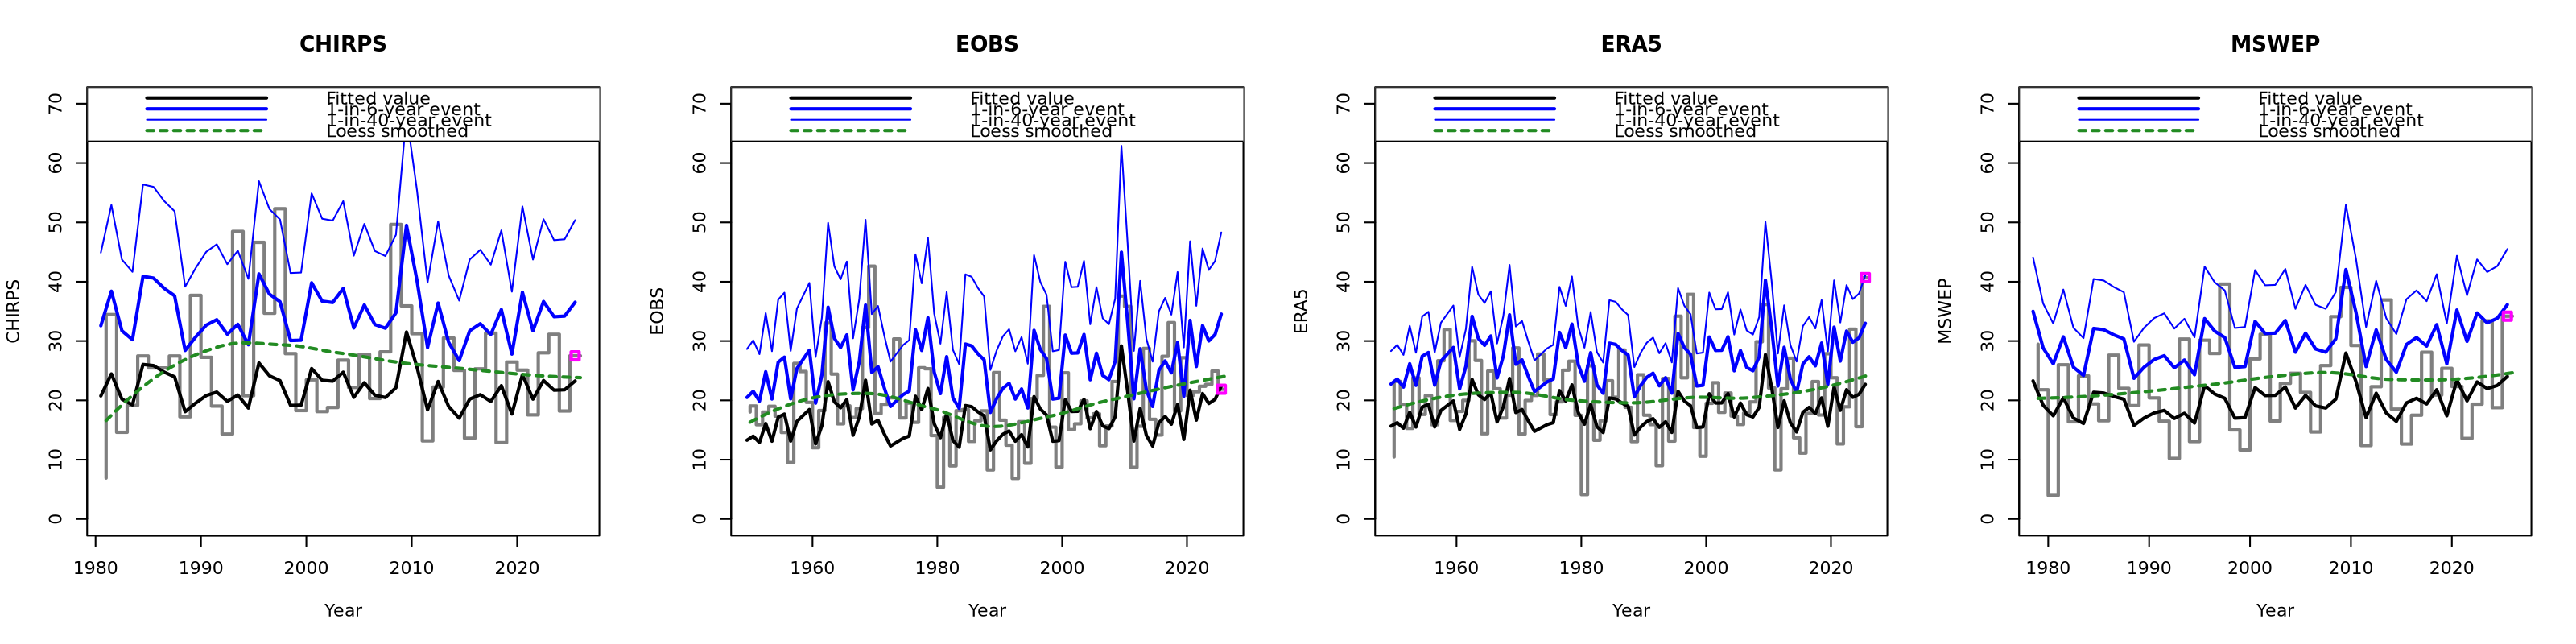

In [125]:
prep_window(c(1,4))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_trend(mdl_gmstnao_fixeddisp[[mnm]], main = mnm, ylim = c(0,70))
# }

for (mnm in names(mdl_gmstnaores_fixeddisp)[1:4]) {
    plot_trend(mdl_gmstnaores_fixeddisp[[mnm]], main = mnm, ylim = c(0,70))
}

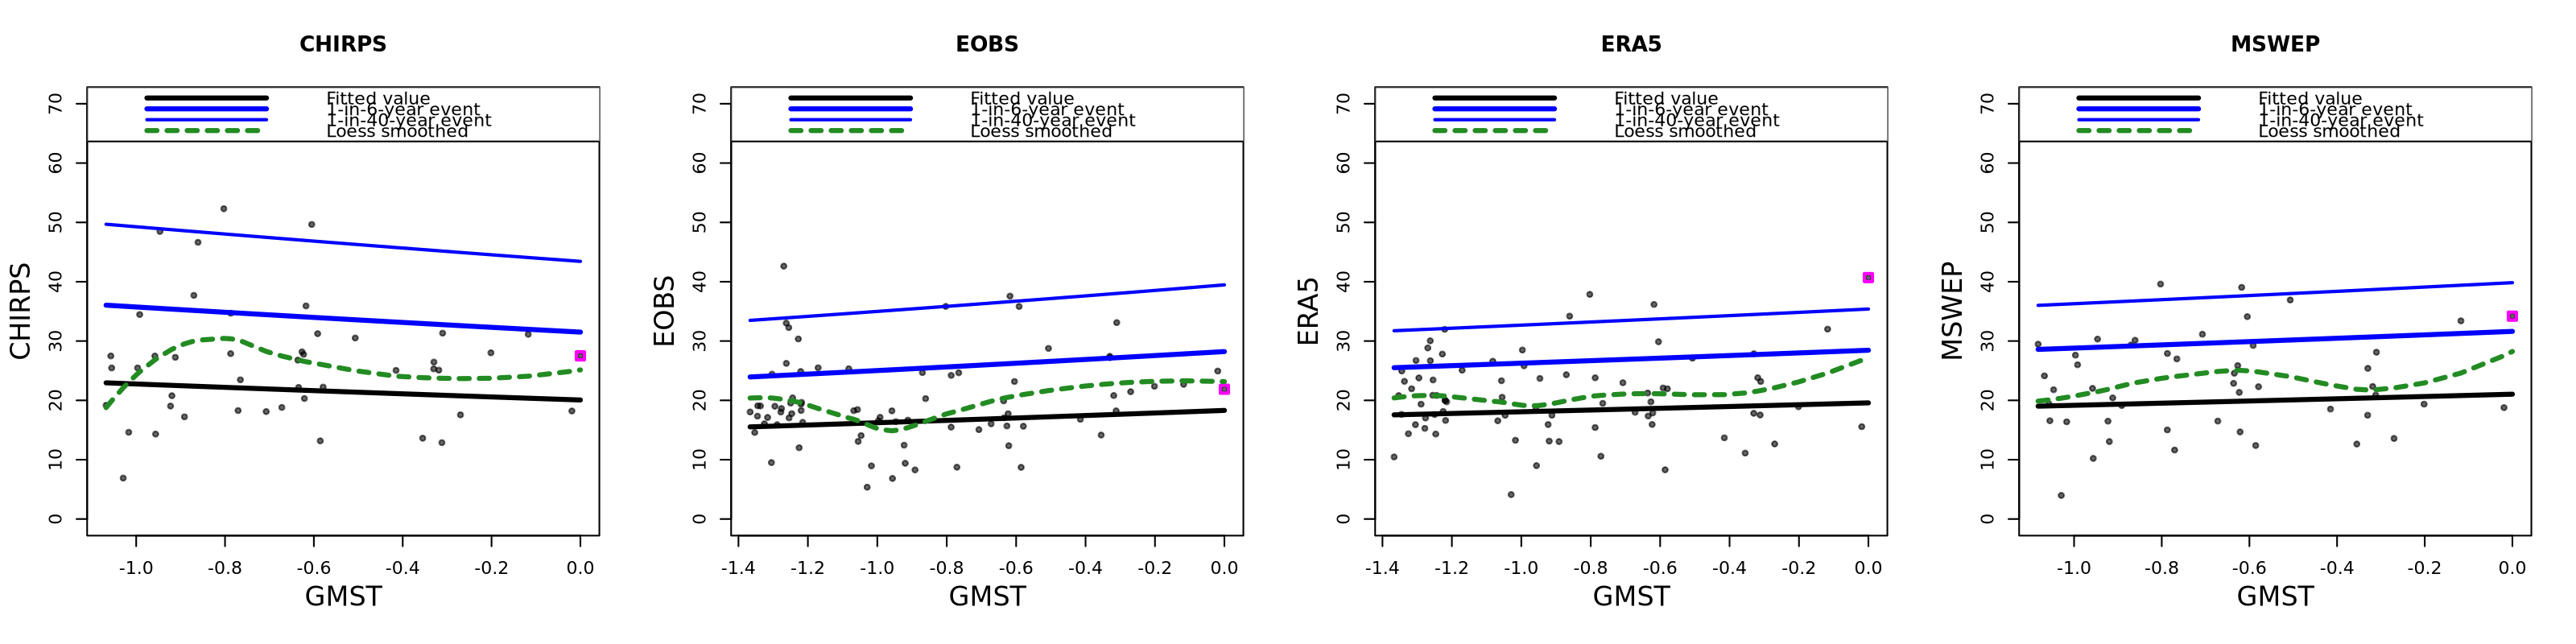

In [126]:
prep_window(c(1,4))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_covtrend(mdl_gmstnao_fixeddisp[[mnm]], "gmst", main = mnm, ylim = c(0,70))
# }
for (mnm in names(mdl_gmstnaores_fixeddisp)) {
    plot_covtrend(mdl_gmstnaores_fixeddisp[[mnm]], "gmst", main = mnm, ylim = c(0,70))
}

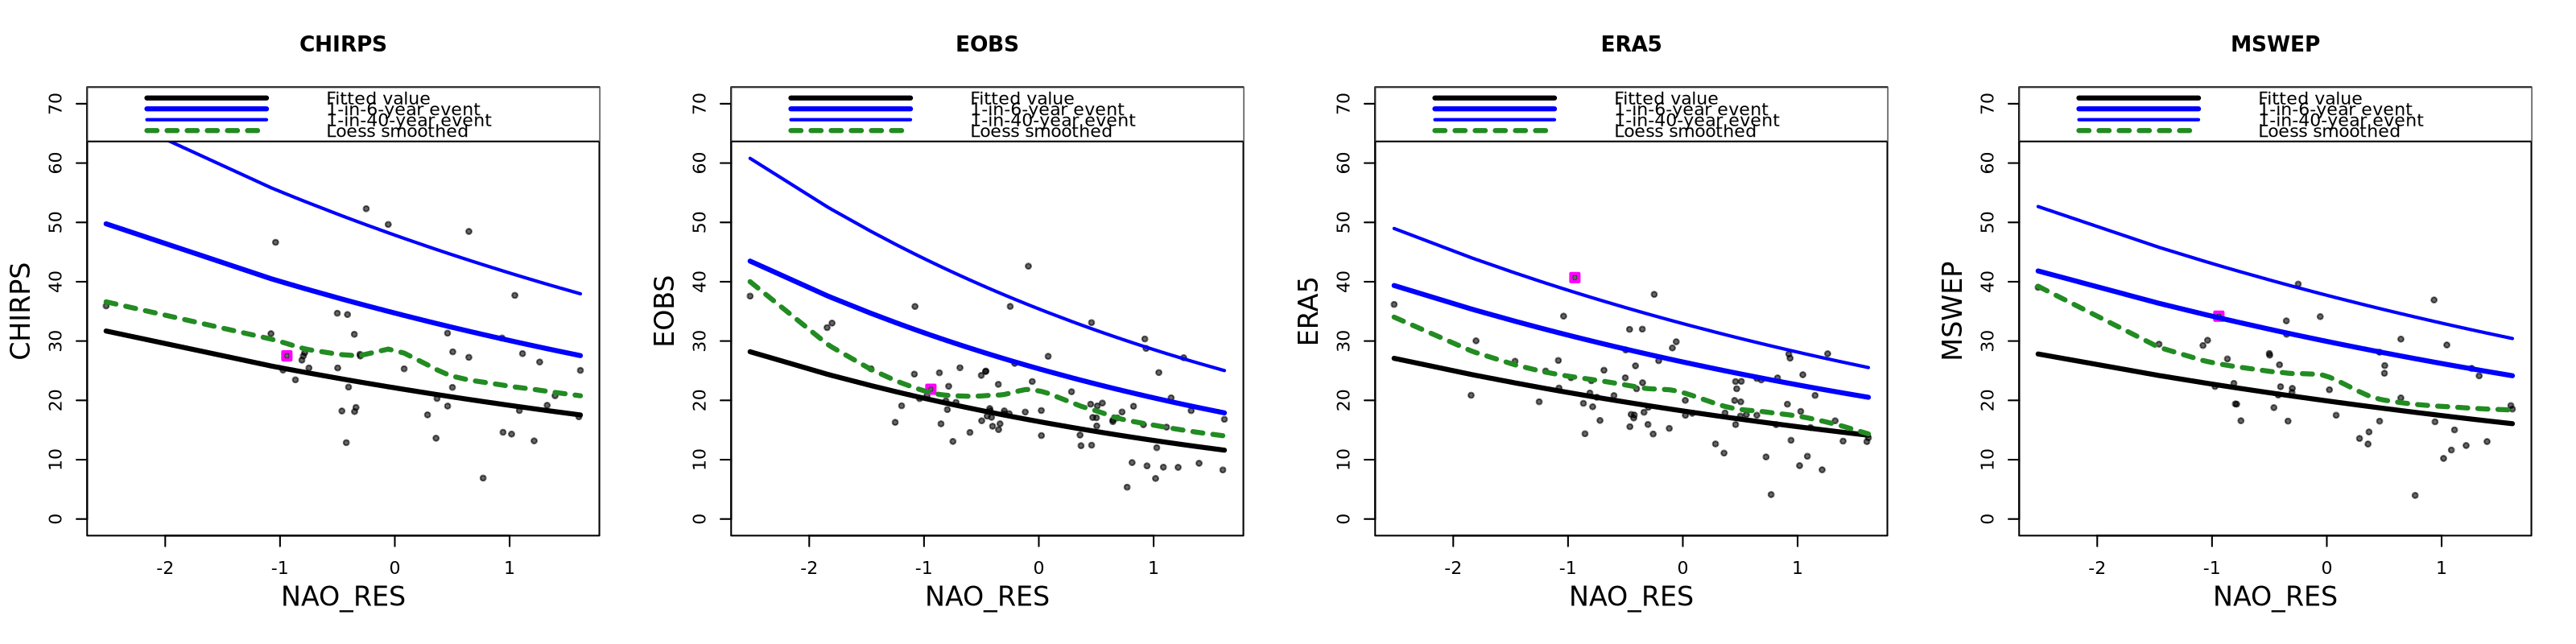

In [127]:
prep_window(c(1,4))

# for (mnm in names(mdl_gmstnao_fixeddisp)) {
#     plot_covtrend(mdl_gmstnao_fixeddisp[[mnm]], "nao", main = mnm, ylim = c(0,70))
# }

for (mnm in names(mdl_gmstnaores_fixeddisp)) {
    plot_covtrend(mdl_gmstnaores_fixeddisp[[mnm]], "nao_res", main = mnm, ylim = c(0,70))
}

In [128]:
boot_res <- sapply(mdl_gmstnaores_fixeddisp, boot_ci, cov_f = cov_2026, cov_cf = cov_cf, simplify = F)

In [131]:
# sapply(names(boot_res), function(ds_nm) write.csv(boot_res[[ds_nm]], paste0("res/res-obs_rx1day_gmst+naores_",tolower(ds_nm),".csv")))

$CHIRPS
NULL

$EOBS
NULL

$ERA5
NULL

$MSWEP
NULL

In [147]:
cols <- c("event_magnitude", "return_period", "PR_pi", "dI_rel_pi", "PR_naoneutral", "dI_rel_naoneutral")
t(sapply(cols, function(cnm) {
    apply(signif(t(sapply(boot_res, "[", cnm, )), 3), 1, function(r) {
        paste0(r[1], " (",r[2], ", ", r[3], ")")
    })
}))

,CHIRPS,EOBS,ERA5,MSWEP
event_magnitude,"27.5 (27.5, 27.5)","21.9 (21.9, 21.9)","40.7 (40.7, 40.7)","34.2 (34.2, 34.2)"
return_period,"2.24 (1.38, 6.57)","1.52 (1.2, 2.16)","36 (7.83, Inf)","4.51 (1.98, 22.5)"
PR_pi,"0.71 (0.191, 1.89)","1.39 (0.834, 2.12)","4.72 (0.0472, Inf)","2.01 (0.162, Inf)"
dI_rel_pi,"-15.1 (-49.6, 33.1)","16.9 (-7.01, 43)","10.9 (-20.2, 38.3)","12.9 (-29, 68.8)"
PR_naoneutral,"1.49 (1.15, 2.38)","1.57 (1.19, 2.5)","12.1 (2.64, Inf)","2.06 (1.12, 20)"
dI_rel_naoneutral,"14.4 (3.6, 29)","22.4 (10.6, 37.7)","16 (9.71, 25)","13.3 (3, 33.7)"


In [148]:
sapply(mdl_gmstnaores_fixeddisp, rsquared, simplify = F)

$CHIRPS
         r2      r2.adj 
-0.05733713 -0.10651560 

$EOBS
        r2     r2.adj 
0.07572584 0.05074546 

$ERA5
        r2     r2.adj 
0.10562624 0.08145398 

$MSWEP
        r2     r2.adj 
0.06346195 0.02183804

In [156]:
sapply(colnames(df)[-(1:4)], function(cnm) {
    c("gmst" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "gmst", varnm = cnm, lower = F))[1],
      "nao" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "nao", varnm = cnm, lower = F))[1],
      "nao_res" = rsquared(fit_ns("gev", "fixeddisp", df[!is.na(df[,cnm]),], covnm = "nao_res", varnm = cnm, lower = F))[1])
}, simplify = T) * 100

,CHIRPS,EOBS,ERA5,MSWEP
gmst.r2,-17.67049,-16.305580,-13.556169,-11.172434
nao.r2,-6.18776,1.002298,4.692296,3.448237
nao_res.r2,-7.84274,5.804816,9.068975,5.625477
